https://youtu.be/cEgF0YknpZw

## Train custom instance segmentation model using Detectron2 - on your own dataset

Create your own dataset by annotating for object detection using your favorite annotation software that can export annotations as COCO JSON format. I have used https://www.makesense.ai/ for my tutorial. I used the polygon tool to annotate objects and exported annotations as, "Single file in COCO JSON format"

**Install Detectron2**

In [1]:
import locale
#locale.getpreferredencoding = lambda: "UTF-8"
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 2.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15737, done.
remote: Total 15737 (delta 0), reused 0 (delta 0), pack-reused 15737
Receiving objects: 100% (15737/15737), 6.32 MiB | 8.79 MiB/s, done.
Resolving deltas: 100% (11487/11487), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


The default models are trained on natural images so let us go ahead and load a natural image to see if detectron is working. **We will run a pre-trained model on this image.**

# Train on a custom dataset

Import the necessary function to register datasets in the COCO format. Let us register both the training and validation datasets. Please note that we are working with training (and validation) data that is is the coco format where we have a single JSON file that describes all the annotations from all training images. <p>
Here, we are naming our training data as 'my_dataset_train' and the validation data as 'my_dataset_val'.



In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train_1CClear", {}, "/content/drive/MyDrive/ColabNotebooks/data/JSON_files/training_clearview_358_of_358.json", "/content/drive/MyDrive/ColabNotebooks/data/liver_images/train")
register_coco_instances("my_dataset_val_1CClear", {}, "/content/drive/MyDrive/ColabNotebooks/data/JSON_files/validation_clearview_50.json", "/content/drive/MyDrive/ColabNotebooks/data/liver_images/val")



Let us extract the metadata and dataset dictionaries for both training and validation datasets. These can be used later for other purposes, like visualization, model training, evaluation, etc. We will see a visualization example right away.

In [5]:
train_metadata = MetadataCatalog.get("my_dataset_train_1CClear")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train_1CClear")

[07/05 18:01:45 d2.data.datasets.coco]: Loading /content/drive/MyDrive/ColabNotebooks/data/JSON_files/training_clearview_358_of_358.json takes 2.03 seconds.
[07/05 18:01:45 d2.data.datasets.coco]: Loaded 350 images in COCO format from /content/drive/MyDrive/ColabNotebooks/data/JSON_files/training_clearview_358_of_358.json


In [6]:
val_metadata = MetadataCatalog.get("my_dataset_val_1CClear")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val_1CClear")


[07/05 18:01:58 d2.data.datasets.coco]: Loaded 50 images in COCO format from /content/drive/MyDrive/ColabNotebooks/data/JSON_files/validation_clearview_50.json


In [7]:
from matplotlib import pyplot as plt
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# Train

Now we are ready to train a Mask R-CNN model using the Detectron2 library. We start by setting up a configuration file (.cfg) for the model. The configuration file contains many details including the output directory path, training dataset information, pre-trained weights, base learning rate, maximum number of iterations, etc.

In [8]:
from detectron2.engine import DefaultTrainer
cfg = get_cfg()
#cfg.MODEL.DEVICE='cpu'
cfg.OUTPUT_DIR = "/content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models_1cClear"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train_1CClear",)
cfg.DATASETS.TEST = ("")
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 1 class.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available
# print('*****************')
# print(cfg)

[07/05 18:04:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 238MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


Train

In [ ]:
trainer.train() #Start the training process

[07/05 18:04:23 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan fai

[07/05 18:04:59 d2.utils.events]:  eta: 0:16:12  iter: 19  total_loss: 1.792  loss_cls: 0.6779  loss_box_reg: 0.3528  loss_mask: 0.6916  loss_rpn_cls: 0.04348  loss_rpn_loc: 0.0178    time: 1.4671  last_time: 1.5651  data_time: 1.1139  last_data_time: 1.1474   lr: 4.9953e-06  max_mem: 2579M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[07/05 18:05:26 d2.utils.events]:  eta: 0:15:48  iter: 39  total_loss: 1.853  loss_cls: 0.6319  loss_box_reg: 0.4528  loss_mask: 0.6854  loss_rpn_cls: 0.06052  loss_rpn_loc: 0.02123    time: 1.2962  last_time: 1.0171  data_time: 0.6752  last_data_time: 0.5113   lr: 9.9902e-06  max_mem: 2579M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[07/05 18:05:57 d2.utils.events]:  eta: 0:15:14  iter: 59  total_loss: 1.58  loss_cls: 0.5058  loss_box_reg: 0.3277  loss_mask: 0.6707  loss_rpn_cls: 0.032  loss_rpn_loc: 0.0178    time: 1.3747  last_time: 0.4443  data_time: 1.0688  last_data_time: 0.0016   lr: 1.4985e-05  max_mem: 2582M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[07/05 18:06:27 d2.utils.events]:  eta: 0:15:34  iter: 79  total_loss: 1.577  loss_cls: 0.4225  loss_box_reg: 0.4378  loss_mask: 0.6439  loss_rpn_cls: 0.03678  loss_rpn_loc: 0.01722    time: 1.4114  last_time: 2.2163  data_time: 1.0504  last_data_time: 1.6578   lr: 1.998e-05  max_mem: 2582M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[07/05 18:06:57 d2.utils.events]:  eta: 0:16:31  iter: 99  total_loss: 1.389  loss_cls: 0.3373  loss_box_reg: 0.3205  loss_mask: 0.6385  loss_rpn_cls: 0.0594  loss_rpn_loc: 0.02092    time: 1.4248  last_time: 0.7430  data_time: 0.9819  last_data_time: 0.2162   lr: 2.4975e-05  max_mem: 2582M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[07/05 18:07:35 d2.utils.events]:  eta: 0:16:44  iter: 119  total_loss: 1.311  loss_cls: 0.3095  loss_box_reg: 0.2701  loss_mask: 0.6096  loss_rpn_cls: 0.04995  loss_rpn_loc: 0.01884    time: 1.5049  last_time: 0.8776  data_time: 1.4168  last_data_time: 0.4469   lr: 2.997e-05  max_mem: 2582M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[07/05 18:08:02 d2.utils.events]:  eta: 0:16:21  iter: 139  total_loss: 1.373  loss_cls: 0.3263  loss_box_reg: 0.412  loss_mask: 0.587  loss_rpn_cls: 0.03586  loss_rpn_loc: 0.01796    time: 1.4855  last_time: 0.8889  data_time: 0.8959  last_data_time: 0.3855   lr: 3.4965e-05  max_mem: 2582M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[07/05 18:08:33 d2.utils.events]:  eta: 0:15:58  iter: 159  total_loss: 1.277  loss_cls: 0.2806  loss_box_reg: 0.3334  loss_mask: 0.5679  loss_rpn_cls: 0.04219  loss_rpn_loc: 0.02011    time: 1.4917  last_time: 1.0306  data_time: 1.0626  last_data_time: 0.6229   lr: 3.996e-05  max_mem: 2583M


Save the config file, for potential future use

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "/content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models_1cClear/config_1cClear.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

# Inference & evaluation using the trained model

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.9]
predictor = DefaultPredictor(cfg)
print(cfg)

[11/16 12:17:21 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models_1cClear/model_final.pth ...
CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: 
  TRAIN: ('my_dataset_train_1CClear',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    S

Verify segmentation on random validation images

/content/drive/MyDrive/ColabNotebooks/data/liver_images/val/image341-other.jpg


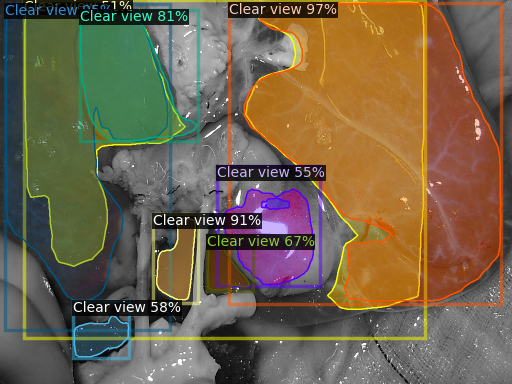

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    print(d["file_name"])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Check average precision and recall. (Need more validation data than just 2 images with handful of annotations)

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val_1CClear", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val_1CClear")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[11/16 12:39:10 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[11/16 12:39:10 d2.data.datasets.coco]: Loaded 50 images in COCO format from /content/drive/MyDrive/ColabNotebooks/data/JSON_files/validation_clearview_50.json
[11/16 12:39:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/16 12:39:10 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/16 12:39:10 d2.data.common]: Serializing 50 elements to byte tensors and concatenating them all ...
[11/16 12:39:10 d2.data.common]: Serialized dataset takes 0.07 MiB
[11/16 12:39:10 d2.evaluation.evaluator]: Start inference on 50 batches
[11/16 12:39:23 d2.evaluation.evaluator]: Inference done 11/50. Dataloading: 0.1011 s/iter. Inference: 0.1953 s/iter. Eval: 0.4640 s/iter. Total: 0.7603 s/iter. ETA=0:00:29
[11/16 12:39:2

**Load a new image and segment it.**

In [ ]:
new_im = cv2.imread("/content/drive/MyDrive/ColabNotebooks/data/liver_images/val/Liver - 0004 - 03- posterior.jpg")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])


**Process multiple images in a directory and save the results in an output directory**

In [ ]:
# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/ColabNotebooks/data/liver_images/val"

# Output directory where the segmented images will be saved
output_directory = "/content/drive/MyDrive/ColabNotebooks/data/test_results_clear"  # Replace this with the path to your desired output directory

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")


**Segment images and save object level information into a csv file.**




In [ ]:
import csv
from skimage.measure import regionprops, label


# Assuming you have already defined the 'predictor' object and loaded the model.
# Also, make sure 'metadata' is defined appropriately.

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/ColabNotebooks/data/liver_images/val"

# Output directory where the CSV file will be saved
output_csv_path = "/content/drive/MyDrive/ColabNotebooks/data/test_results_clear/output_objects.csv"  # Replace this with the path to your desired output CSV file

# Open the CSV file for writing
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Write the header row in the CSV file
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox"])  # Add more columns as needed for other properties

    # Loop over the images in the input folder
    for image_filename in os.listdir(input_images_directory):
        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)

        # Perform prediction on the new image
        outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

        # Convert the predicted mask to a binary mask
        mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)

        # Get the predicted class labels
        class_labels = outputs["instances"].pred_classes.to("cpu").numpy()

        # Debugging: print class_labels and metadata.thing_classes
        #print("Class Labels:", class_labels)
        #print("Thing Classes:", train_metadata.thing_classes)

        # Use skimage.measure.regionprops to calculate object parameters
        labeled_mask = label(mask)
        props = regionprops(labeled_mask)

        # Write the object-level information to the CSV file
        for i, prop in enumerate(props):
            object_number = i + 1  # Object number starts from 1
            area = prop.area
            centroid = prop.centroid
            bounding_box = prop.bbox

            # Check if the corresponding class label exists
            if i < len(class_labels):
                class_label = class_labels[i]
                class_name = train_metadata.thing_classes[class_label]
            else:
                # If class label is not available (should not happen), use 'Unknown' as class name
                class_name = 'Unknown'

            # Write the object-level information to the CSV file
            csvwriter.writerow([image_filename, class_name, object_number, area, centroid, bounding_box])  # Add more columns as needed for other properties

print("Object-level information saved to CSV file.")


Object-level information saved to CSV file.


**Generate plots to understand the objects**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the CSV file containing the object-level information
csv_file_path = "/content/drive/MyDrive/ColabNotebooks/data/test_results_clear/output_objects.csv"  # Update with your CSV file path

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Get class names from train_metadata.thing_classes
class_names = train_metadata.thing_classes

# Group the data by both "File Name" and "Class Name" and calculate the average number of objects per image for each class
# first group the data by both "File Name" and "Class Name" and count the number of objects within each group.
#Then, group the data by "Class Name" only and calculate the mean of the counts, which gives us the average number of objects per image for each class.
avg_objects_per_class = df.groupby(["File Name", "Class Name"])["Object Number"].count().reset_index()
avg_objects_per_class = avg_objects_per_class.groupby("Class Name")["Object Number"].mean().reset_index()

# Plot: Average number of objects per image for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Number of Objects per Image")
plt.title("Average Number of Objects per Image for Each Class")
plt.tight_layout()
plt.show()


# Group the data by class and calculate the average area of objects for each class
avg_area_per_class = df.groupby("Class Name")["Area"].mean().reset_index()

# Plot: Average area of objects for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Area of Objects")
plt.title("Average Area of Objects for Each Class")
plt.tight_layout()
plt.show()




**Saving binary (actually multinary) images for each class for further processing.** Here, for each input image we will save n images corresponding to the number of classes. In our example, we will save 4 images for each image corresponding to the 4 classes. Each of these images will contain objects numbered 1, 2, 3, etc. - basically instance segmentation like images. These images can be used for further downstream processing.

In [ ]:
import os
import cv2
import numpy as np
import torch
from detectron2.utils.visualizer import Visualizer

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test"

# Output directory where the segmented images will be saved
output_directory = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test_results_instance"  # Replace this with the path to your desired output directory

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # Create a dictionary to store the mask for each class with unique integer labels
    class_masks = {class_name: torch.zeros_like(outputs["instances"].pred_masks[0], dtype=torch.uint8, device=torch.device("cuda:0"))
                   for class_name in train_metadata.thing_classes}

    # Assign a unique integer label to each object in the mask
    for i, pred_class in enumerate(outputs["instances"].pred_classes):
        class_name = train_metadata.thing_classes[pred_class]
        class_masks[class_name] = torch.where(outputs["instances"].pred_masks[i].to(device=torch.device("cuda:0")),
                                              i + 1,
                                              class_masks[class_name])

    # Save the masks for each class with unique integer labels
    for class_name, class_mask in class_masks.items():
        # Convert the tensor to a NumPy array and then to a regular (CPU) array
        class_mask_np = class_mask.cpu().numpy()

        # Create the output filename with _class_name_result.png extension
        class_filename = os.path.splitext(image_filename)[0] + f"_{class_name}_result.png"
        class_output_path = os.path.join(output_directory, class_filename)

        # Save the image with unique integer labels
        cv2.imwrite(class_output_path, class_mask_np.astype(np.uint8))

print("Segmentation of all images completed.")


Segmentation of all images completed.
